# HW02: Tokenization

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

In [ ]:
#Import the AG news dataset (same as hw01)
#Download them from here 
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

--2023-03-09 07:58:55--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M  --.-KB/s    in 0.1s    

2023-03-09 07:58:56 (207 MB/s) - ‘train.csv’ saved [29470338/29470338]



,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


## Preprocess Text

In [ ]:
import spacy
dfs = df.sample(50)
nlp = spacy.load('en_core_web_sm')

##TODO use spacy to split the documents in the sampled dataframe (dfs) in sentences and tokens
##TODO print the first sentence of the first document in your sample

dfs['sentences'] = dfs['text'].apply(lambda x: [s for s in nlp(x).sents])
dfs['tokens'] = dfs['text'].apply(lambda x: nlp(x))

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Named Entities

Let's compute the ratio of named entities starting with a capital letter, e.g. if we have "University of Chicago" as a NE, "University" and "Chicago" are capitalized, "of" is not, thus the ratio is 2/3.

In [ ]:
dfs["tokenized"] = dfs["text"].apply(lambda x: nlp(x))

In [ ]:
##TODO print the ratio of tokens being part of a named entity span starting with a capital letter (doc.ents)

cap = 0
n = 0
for doc in dfs["tokenized"]:
    for token in doc.ents:
        if token.text[0].isupper():
            cap += 1
print(cap/n)

In [ ]:
##TODO print the ratio of capitalized tokens not being part of a named entity span (have no token.ent_type_)

cap = 0
n = 0
for doc in dfs["tokenized"]:
    for token in doc:
        if not token.ent_type_:
            if token.text[0].isupper():
                cap += 1
            n += 1

print(cap/n)

## Term Frequencies

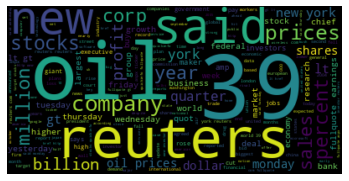

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

tfidf = TfidfVectorizer(min_df=0.01, 
                        max_df=0.9,  
                        max_features=1000,
                        stop_words='english',
                        use_idf=True, # the new piece
                        ngram_range=(1,2))

##TODO using the whole sample, produce a world cloud with bigrams for label == business using tfidf frequencies
X_tfidf = tfidf.fit_transform(df['text'])

vocab = tfidf.get_feature_names_out()
slicer = df['label'] == 'business'
f = X_tfidf[slicer.values]
total_freqs = list(np.array(f.sum(axis=0))[0])
fdict = dict(zip(vocab,total_freqs))
# generate word cloud of words with highest counts
wordcloud = WordCloud().generate_from_frequencies(fdict) 
plt.clf()
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.show()

## Supervised Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

##TODO compute the number of words per document (excluding stopwords)
df['word_count'] = df['text'].apply(lambda x: len(list(nlp(x))))

##TODO get the most predictive features of the number of words per document using first f_class and then chi2
#%% top 10 features by  ANOVA F-value:
select = SelectKBest(f_classif, k=10)
select.fit(X, Y)
[vocab[i] for i in np.argsort(select.scores_)[:10]]

In [ ]:
#%% Univariate feature selection using chi2
select = SelectKBest(chi2, k=10)
Y = df['word_count']
X_new = select.fit_transform(X, Y)
# top 10 features by chi-squared:
vocab = vec.get_feature_names()
[vocab[i] for i in np.argsort(select.scores_)[:10]]

Are the results different? What could be a reason for this? 

## Huggingface Tokenizers

In [ ]:
##TODO tokenize the sentences in the sampled dataframe (dfs) using the DisilBertTokenizer

#!pip install transformers
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# tokenize text
dfs['token_sents'] = dfs['sentences'].apply(lambda x: tokenizer.tokenize(x))

# Parsing

In [ ]:
import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df = df.sample(n=10000) # # only use 10K datapoints
df.head()

,label,title,lead,text
107963,world,WHO urges poor nations to offer women dewormin...,PRETORIA -- The World Health Organization urge...,WHO urges poor nations to offer women dewormin...
65998,sci/tech,S. Korea Backs UN Meeting on Stem Cell Research,South Korea said on Tuesday it asked the Unite...,S. Korea Backs UN Meeting on Stem Cell Researc...
52589,business,"Netegrity is bought, will fire",A Waltham maker of security software is being ...,"Netegrity is bought, will fire A Waltham maker..."
44522,world,Italian Officials Dispute Reports of Ransom,Italy #39;s government dismissed reports Wedne...,Italian Officials Dispute Reports of Ransom It...
18532,world,Three Palestinians die in Gaza Strip,Palestinian sources reported early Saturday th...,Three Palestinians die in Gaza Strip Palestini...


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
#TODO preprocess the corpus using spacy
dfs['doc'] = dfs['text'].apply(nlp)

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit]
dfs['tokenized'] = dfs['doc'].apply(lambda x: tokenize(x, nlp))

### Information Extraction

In [ ]:
def extract_subject_verb_pairs(sent):
    subjs = [w for w in sent if w.dep_ == "nsubj"]
    pairs = [(w.lemma_.lower(), w.head.lemma_.lower()) for w in subjs]
    return pairs
##TODO extract the subject-verbs pairs and print the result for the second document

doc = nlp(df.iloc[1]['text'])
df["subj-verb-pairs"] = extract_subject_verb_pairs(doc)

from collections import Counter
counter = Counter()

In [ ]:
##TODO do the same for verbs-object pairs ('dobj')
def extract_verb_object_pairs(sent):
    objs = [w for w in sent if w.dep_ == "dobj"]
    pairs = [(w.lemma_.lower(), w.head.lemma_.lower()) for w in objs]
    return pairs
##TODO extract the subject-verbs pairs and print the result for the second document

doc = nlp(df.iloc[1]['text'])
df["verb-objs-pairs"] = extract_verb_object_pairs(doc)
##TODO create a list ranking the most common pairs and print the first 10 items

In [ ]:
##TODO do the same for adjectives-nouns pairs ('amod')
ef extract_adjectives_nouns_pairs(sent):
    mods = [w for w in sent if w.dep_ == "amod"]
    pairs = [(w.lemma_.lower(), w.head.lemma_.lower()) for w in mods]
    return pairs

##TODO create a list ranking the most common pairs and print the first 10 items

df["adj-nouns-pairs"] = extract_adjectives_nouns_pairs(doc)

### Exploring cross label dependencies

In [ ]:
##TODO extract all the subject-verbs and verbs-object pairs for the verb "rise"

In [ ]:
##TODO for each label create a list ranking the most common subject-verbs pairs and one for the most common verbs-object pairs
##TODO print the 10 most common pairs for each of the two lists for the labels "world" and "sci/tech"